# CIROH Developers Conference: Hydrological Applications of ML
## CNNs for Predicting Daily Orographic Precipitation Gradients for Atmospheric Downscaling

# Introduction

In this exercise, we'll build a convolutional neural network (CNN) for regression of orographic precipitation gradients of Northern Utah. More complex uses include:

- Semantic image segmentation
- Image denoising or reconstruction
- Working with video streams

But all methods are based around two basic operations: 

- Convolution: in this step, the network learns a series of kernels or filters that transform the original image in some way. These are similar to filters that are used in standard image processing (e.g. low-pass filters), but filters are chosen by how well the transformed image maps to the outcome variable. To put this another way, these filters identify shapes or features that are important in differentiating between different outcomes
- Max-pooling: in this step, the image resolution is transformed. In general, the resolution is halved, by aggregating groups of four pixels in a two by two window. 

In general, these steps are repeated several times. As this progresses, the small shapes identified in the first set of convolutions are progressively combined into larger structures. For example, a series of small curves or lines could be aggregated into a cat's eye.



### Image classification

The basic idea behind image classification is to link *features* of an image to a single label or class. For example, we might have a photograph of a cat, with the label `Cat` and one of a dog with the label `Dog`. The goal of the model is to identify what shapes and colors, and combination of these can help differentiate between these two classes. 

### Data

We'll use formulated orographic precipitation gradients from Bohne et al. 2020 (https://doi.org/10.1175/JHM-D-19-0229.1) subsetted to Northern Utah and atmospheric variables from ERA5 (https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview).


### Setup environment

I'd suggest making a new virtual environment or Conda environment for this exercise:

```
conda create -name tf
conda activate tf
```

You will need to make sure you have the following Python packages installed. Please ask if you have any issues installing these:

- `numpy`
- `pandas`
- `matplotlib`
- `tensorflow`


## OPG Regression

### Data processing
Let's start, as usual, by loading the libraries we'll need for the lab:

In [37]:
# Machine learning library
import tensorflow

# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
from matplotlib import colors
import nclcmaps as ncm

Now we set the path to the data folders and download the datasets. If you have any questions about setting this path, please ask. 

In [38]:
# load in the atmospheric data
path      = "../datasets/era5_atmos/"
IVT       = xr.open_dataset(f"{path}IVT_sfc.nc")
precip    = xr.open_dataset(f"{path}precip_sfc.nc")*1000
temp700   = xr.open_dataset(f"{path}temp_700.nc")-273.15
uwinds700 = xr.open_dataset(f"{path}uwnd_700.nc")
vwinds700 = xr.open_dataset(f"{path}vwnd_700.nc")
hgt500    = xr.open_dataset(f"{path}hgt_500.nc")/9.81

# load in the OPGs
path = "../datasets/facets_and_opgs/"
opg  = pd.read_csv(f"{path}winter_northernUT_opg.csv", index_col=0)
facet_list = opg.columns.values
opg = opg.values

Standardizing the datasets - Since the values between the atmospheric variables contain a large variability in scale, we standardize each variable individually. This levels the playing field, so to speak, so that no atmospheric variable overshadows another. This also applies to the facet OPGs.

In [39]:
IVT       = (IVT - IVT.mean(dim="time")) / IVT.std(dim="time")
precip    = (precip - precip.mean(dim="time")) / precip.std(dim="time")
temp700   = (temp700 - temp700.mean(dim="time")) / temp700.std(dim="time")
uwinds700 = (uwinds700 - uwinds700.mean(dim="time")) / uwinds700.std(dim="time")
vwinds700 = (vwinds700 - vwinds700.mean(dim="time")) / vwinds700.std(dim="time")
hgt500    = (hgt500 - hgt500.mean(dim="time")) / hgt500.std(dim="time")

opg_mean = np.nanmean(opg, axis=0)
opg_std  = np.nanstd(opg, axis=0)
opg = (opg - opg_mean) / opg_std
opg[np.isnan(opg)] = 0

To send the data to the model, combine all atmospheric variables into one variable.

In [40]:
# Combine the atmospheric data into one array
atmos = np.concatenate((IVT.IVT.values[...,np.newaxis], 
                        precip.precip.values[...,np.newaxis],
                        temp700.temp.values[...,np.newaxis],
                        uwinds700.uwnd.values[...,np.newaxis],
                        vwinds700.vwnd.values[...,np.newaxis],
                        hgt500.hgt.values[...,np.newaxis]), axis=3)
print(np.shape(atmos))

(2708, 19, 27, 6)


The above output lists the dimensions of all the atmospheric variables. It contains 2708 observation days or 'images', with a 19 x 27 grid of latitudes and longitudes. Each atmospheric variable represents a channel, here we have 6 channels. If using regular images, you would have 3 channels, for the RGB colors. 

In [41]:
latitude  = 19
longitude = 27
channels  = 6

When creating a ML model, the datasets are split into training, validation, and testing subsets. The model is trained on the training subset, evaluated on the validation subset, and final tested on the testing subset. 

Often, the datasets are randomly shuffled to produce training, validation, and testing subsets. Or the overlap of data can be important and the data is randomly chosen by week, months, or years.

The split of these datasets are user defined, often being a 70/15/15% split.

In [42]:
np.random.seed(42)
rand_ind = np.random.permutation(np.arange(np.shape(atmos)[0]))

train_atmos = atmos[rand_ind[:1896], ...]
test_atmos  = atmos[rand_ind[1896:2302], ...]
val_atmos   = atmos[rand_ind[2302:], ...]

train_opg = opg[rand_ind[:1896], ...]
test_opg  = opg[rand_ind[1896:2302], ...]
val_opg   = opg[rand_ind[2302:], ...]

print(np.shape(test_atmos))

(406, 19, 27, 6)


The last parameter we'll set here is the batch size. This is the same parameter that we have used before to control the rate at which the network weights are updated. We'll also use this to control the number of images that are loaded into memory at any step. This is very useful if you're working on a computer with limited memory (like my old laptop).

In [43]:
batch_size = 32

### Image generators

Keras has several functions to facilitate working with images. We'll start by creating an image *generator*. This acts a bit like a pipeline and will carry various pre-processing steps. These include data augmentation: simple transformations of the images to supplement the original image. We're not going to use that here, but some example code is given in the appendix to illustrate how you might use this.

We'll create a generator for the training images. This will rescale each channel to a 0-1 range (the RGB channels have values between 0 and 255), and it will hold aside 30% of the training images for validation. We'll use this to check for overfitting during the training process.

The next function we'll use is a *flow* function. This function controls how Keras will read in the images for any training step (i.e. any update of the network weights). There are several arguments here:

- `train_image_files_path`: The path to the top-level folder containing the training images
- `train_data_gen`: The image data generator
- `subset`: The subset of images to use from the generator for training. As we set the `validation_size` to 0.3, this will be 1 - 0.3 = 0.7, or 70% of the images
- `target_size`: The size for rescaling each image
- `class_mode`: The type of label used (this will one-hot encode the labels of the images)
- `classes`: The set of categories to use. This is the list we defined earlier and needs to match the subfolder names. If this is not included, this will use all subfolders, and create a list of labels
- `batch_size`: The number of images to import for any update step
- `seed`: a value to initialize the random number generator (this is only there to ensure consistent results)

The function will tell you how many images (and classes) it found in the folder you defined. If this is 0, go back and check the folder path you defined earlier. We'll also create a flow for the validation images. The only difference here is in the definition of the subset. 

Note that these flow generators contain various useful bits of information. For example, to check the number of images (we'll also use this number when training the model):

Or you can get the number of images per class (type of fruit)

Which suggest this is a relatively well-balanced dataset. This generator also contains various information about the files, resolution, channels, etc. 

### Model definition

Let's now set up the model. As this is quite a complex model, we'll do this as a series of steps rather than in one go. First, import all the modules from Keras that we'll need:

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (InputLayer, Conv2D,
                          Dense,
                          ReLU,LeakyReLU,
                          BatchNormalization, 
                          MaxPooling2D, 
                          Dropout,
                          Flatten)
from tensorflow.keras.optimizers import RMSprop

Now, create a template sequential model:

In [45]:
model = Sequential()

Next we add the first hidden layer. This is a convolutional layer, where we'll create 16 filters (or convolutions) based on the original images, with a 3x3 kernel. We'll pad the output of this layer so that it has the same size as the input (`same`). Note that we also need to define the size of the input tensors (width, height and channels). 

In [46]:
model.add(InputLayer(shape=(latitude, longitude, channels)))
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'same'))

We'll then take the output of this layer and pass it through a ReLU activation function (this could have been included directly in the convolutional layer, but this allows a little more control on the process):

In [47]:
model.add(ReLU())

Now, we add a max-pooling layer. As a reminder, this reduces the resolution of the output from the previous layer by a simple filter, forcing the next layer of the network to focus on larger image features. We'll also add a dropout layer. This is a form of regularization. It randomly sets some connection weights to 0 (i.e. having no contribution to the model), which can reduce overfitting.

In [48]:
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(.25))

Let's add another convolutional layer, this time with 32 filters, and pass this through a different activation function (a leaky ReLU)

In [49]:
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same'))
model.add(LeakyReLU(0.5))

We'll take the output of this function and normalize the weights. This is a simple method that adjusts the mean weight to close to zero and reduces the amount variation. This helps avoid gradient problems with very small or very large weights

In [50]:
model.add(BatchNormalization())

And we'll run the output of this through a max-pooling function with dropout:

In [51]:
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(.25))

Now we'll add layers to connect the output of this last max-pooling step to the output (the fruit classes). The first thing we need to do is to flatten the output. The output of the max-pooling is a tensor of shape (5, 5, 32). The size of 5 is a result of the two max-pooling operations and the 32 is the number of filters from the second convolution. The `Flatten()` function will flatten this into a rank 1 tensor of shape (800). 

In [52]:
model.add(Flatten())

Next we'll pass this flattened layer through a dense layer, with a ReLU activation and a dropout

In [53]:
model.add(Dense(units = 100))
model.add(ReLU())
model.add(Dropout(.5))

Finally, we need to output predictions. As this is a multiclass task, the final layer needs to have the same number of nodes as classes (16). This is passed through a softmax activation function. This transforms the predictions for all classes into probabilities (i.e. they have to sum to 1). 

In [54]:
model.add(Dense(units = len(facet_list), activation = 'softmax'))

More practically, we'll create a function that will build the model in one go. This will allow us to easily create new versions for testing. 

In [55]:
def create_model():
    model = Sequential([  
        InputLayer(shape=(latitude, longitude, channels)),
        Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size = (2,2)),
        Dropout(.25),
        Flatten(),
        Dense(units = 100, activation = 'relu'),
        Dense(units = 100, activation = 'relu'),
        Dropout(.25),
        Dense(units = len(facet_list))
    ])
    return model

Let's take a look at the whole thing:

In [56]:
model = create_model()
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 19, 27, 16)     │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 9, 13, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 9, 13, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 9, 13, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 4, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 100)            │        76,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,678 (373.74 KB)

 Trainable params: 95,614 (373.49 KB)

 Non-trainable params: 64 (256.00 B)

Our model has a little under 87,000 parameters or weights to train (hence the need for a lot of images). Note that there are small set of non-trainable parameter from the normalization layer. 

We can also generate a simple visualization:

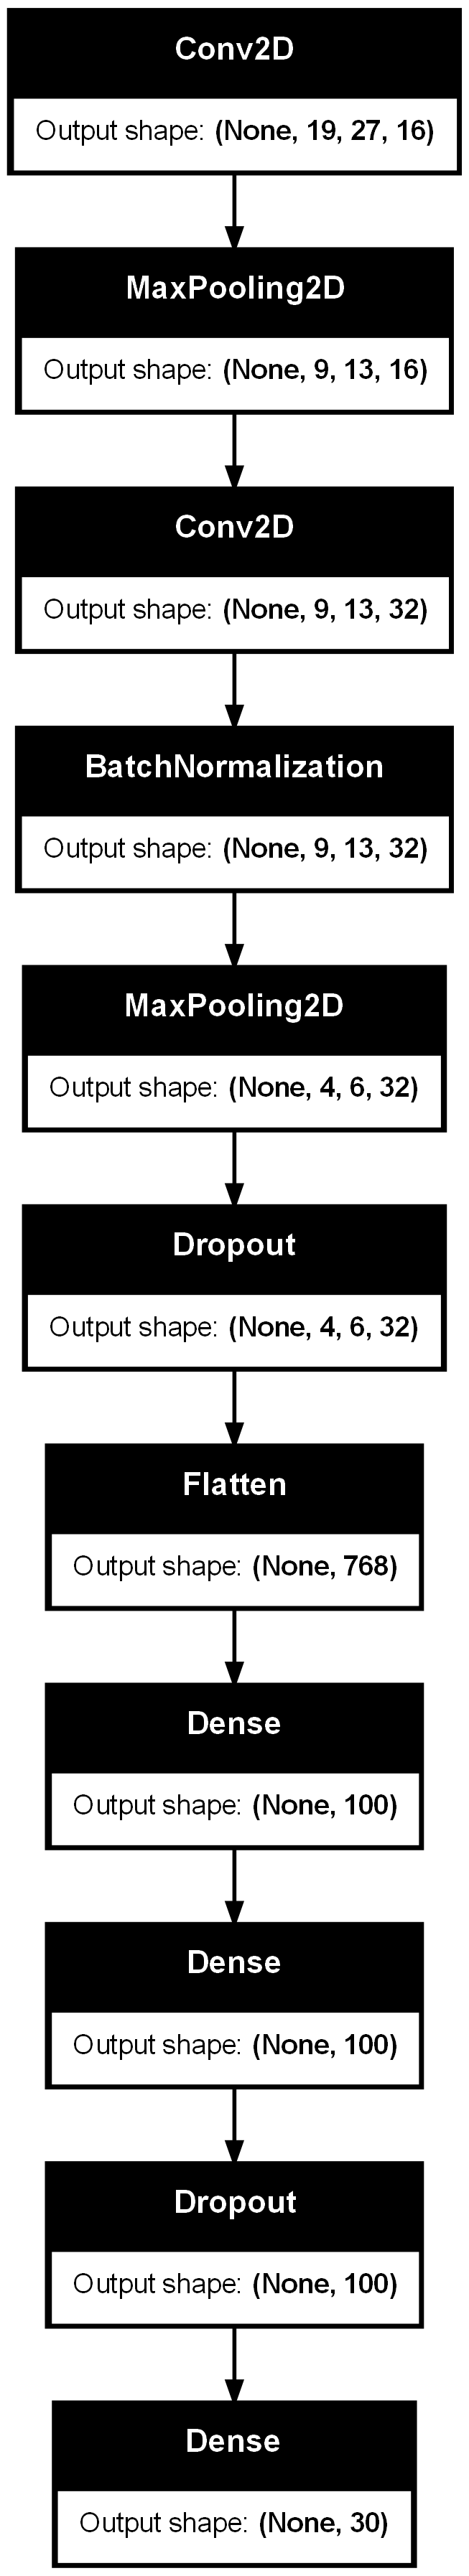

In [57]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

The next step is to compile the model. This asss an optimization function, a loss function and performance metric. A good option for the loss function is `mean_squared_error`, which tries to ..., and we'll use a backpropagation optimizer. The metric is the error between the predicted class and observed class aggregated across all samples. Accuracy is sthe simplest of these for classification exercises and gives the proportion of all images that are correctly classified.

In [58]:
model.compile(loss = 'mean_squared_error', 
              metrics = ["mean_absolute_error"], 
              optimizer = RMSprop())

### Training the model

We'll now train the model for 20 epochs using the `fit()` method upon our built model. We specify:

- `train_atmos`: The training subset of the atmospheric variables
- `train_opg`: The training subset of the observed OPGs
- `batch_size`: The number of samples or observation days used per gradient update.
- `epochs`: The number of full training iterations.
- `validation_data`: The validation subset of the atmospheric variables and observed OPGs

This takes a few minutes to train (on my laptop). It's worth remembering what is going on here: the algorithm is reading in batches of 32 images, rescaling them, updating model weights through back propagation and then repeating the whole thing 50 times. As we previously defined a separate validation subset, this routine will calculate two losses:
- The training loss. This is how accurately the model can predict OPG from the atmospheric 'images' that are being used to update the weights
- The validation loss. This is how accurately the model can predict OPG from a set of atmospheric 'images' that are not used in updating the weights

As the model continues to train, you should see the loss decrease for both of these, but will likely stabilize at a certain point.

In [59]:
epochs = 80
hist = model.fit(train_atmos, train_opg, # training data
                  batch_size = batch_size,
                  epochs = epochs,                        # epochs
                  validation_data = (val_atmos, val_opg), # validation data
                  verbose = 1)                           # print progress

Epoch 1/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8049 - mean_absolute_error: 0.5693 - val_loss: 0.4746 - val_mean_absolute_error: 0.3366
Epoch 2/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4654 - mean_absolute_error: 0.3713 - val_loss: 0.4502 - val_mean_absolute_error: 0.3296
Epoch 3/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3846 - mean_absolute_error: 0.3392 - val_loss: 0.4102 - val_mean_absolute_error: 0.3259
Epoch 4/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3730 - mean_absolute_error: 0.3313 - val_loss: 0.4182 - val_mean_absolute_error: 0.3221
Epoch 5/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3643 - mean_absolute_error: 0.3240 - val_loss: 0.3893 - val_mean_absolute_error: 0.3164
Epoch 6/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3499 - mean_absolute_error: 0.3209 - val_loss: 0.3958 - val_mean_absolute_error: 0.3329
Epoch 7/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3371 - mean_absolute_error: 0.3123 - val_loss: 0.364

Now plot the evolution of the loss function and the actual versus predicted OPGs:

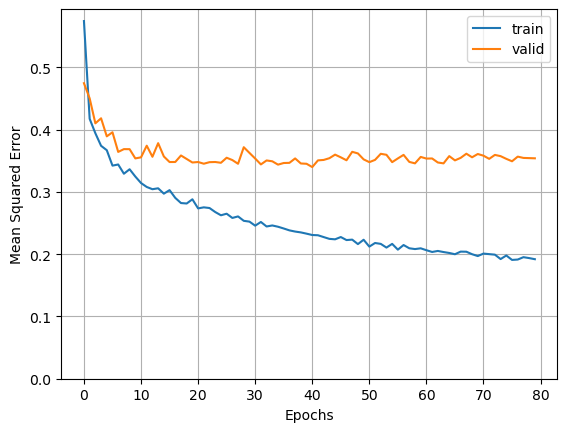

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


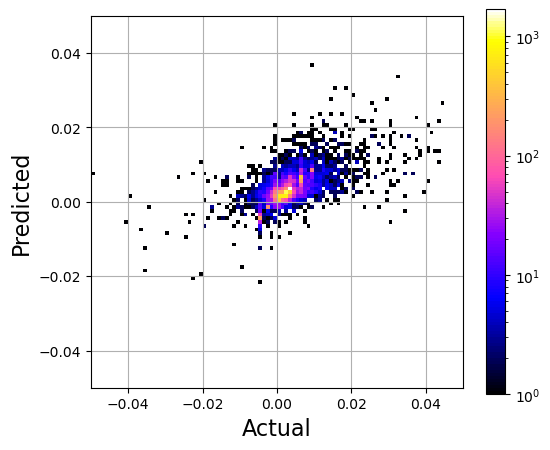

In [60]:
def plot_loss(hist_obs):
    plt.plot(hist_obs.history['loss'], label='train')
    plt.plot(hist_obs.history['val_loss'], label='valid')
    plt.xlabel("Epochs")
    plt.ylabel("Mean Squared Error")
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_act_pred():
    # Using our fitted model, predict OPGs from the testing subset.
    predicted = model.predict(test_atmos)
    
    # Convert from standardized OPG to mm/m OPG
    actual    = (test_opg * opg_std) + opg_mean
    predicted = (predicted * opg_std) + opg_mean
    
    # Since days without OPG observations are set to zero, lets reshape our OPGs and remove zero OPG days
    actual    = np.reshape(actual, -1)
    predicted = np.reshape(predicted, -1)
    idx       = actual != 0.0 # Identify days with OPG observations
    actual    = actual[idx]
    predicted = predicted[idx]
    
    # Formulate the x and y axis limits
    max_val = np.max((np.max(predicted[:]), np.max(actual[:])))
    min_val = np.min((np.min(predicted[:]), np.min(actual[:])))
    max_val = 0.05
    min_val = -0.05
    
    # Define plot colormap
    cmap_gnuplot2 = ncm.cmap("MPL_gnuplot2")
    
    # Define label sizes
    label_size = 16
    tick_size = 14
    
    # Create Figure
    plt.figure(figsize=(6, 5))
    
    # Formulate the heatmap variables
    heatmap, xedges, yedges = np.histogram2d(np.reshape(actual, -1), np.reshape(predicted, -1), bins=100,
                                 range=[[min_val, max_val],[min_val, max_val]])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    # Plot heatmap
    plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cmap_gnuplot2, norm=colors.LogNorm())
    
    # Add labels, gridlines, and colorbar
    plt.xlabel("Actual", fontsize=label_size)
    plt.ylabel("Predicted", fontsize=label_size)
    plt.grid(True)
    plt.colorbar()


plot_loss(hist)
plot_act_pred()

The plot shows a steep decline in both loss values, but no real improvement beyond epoch 20. It's quite likely that this model has overfit - become too tuned to the training data to allow prediction. There are a variety of ways we can avoid this, but a simple one is to slow the rate at which the model learns. We'll refit the model, but will add a `learning_rate` parameter to the compilation step. 

In [61]:
model = create_model()

model.compile(loss = 'mean_squared_error', 
              metrics = ["mean_absolute_error"], 
              optimizer = RMSprop(learning_rate=1e-4))
epochs = 80
hist = model.fit(train_atmos, train_opg, # training data
                  batch_size = batch_size,
                  epochs = epochs,                        # epochs
                  validation_data = (val_atmos, val_opg), # validation data
                  verbose = 1)                           # print progress

Epoch 1/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2102 - mean_absolute_error: 0.7806 - val_loss: 0.5146 - val_mean_absolute_error: 0.3759
Epoch 2/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6984 - mean_absolute_error: 0.5618 - val_loss: 0.5001 - val_mean_absolute_error: 0.3610
Epoch 3/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5686 - mean_absolute_error: 0.4759 - val_loss: 0.4890 - val_mean_absolute_error: 0.3559
Epoch 4/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4918 - mean_absolute_error: 0.4293 - val_loss: 0.4739 - val_mean_absolute_error: 0.3527
Epoch 5/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4849 - mean_absolute_error: 0.4107 - val_loss: 0.4615 - val_mean_absolute_error: 0.3500
Epoch 6/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4556 - mean_absolute_error: 0.3954 - val_loss: 0.4474 - val_mean_absolute_error: 0.3491
Epoch 7/80
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4206 - mean_absolute_error: 0.3763 - val_loss: 0.438

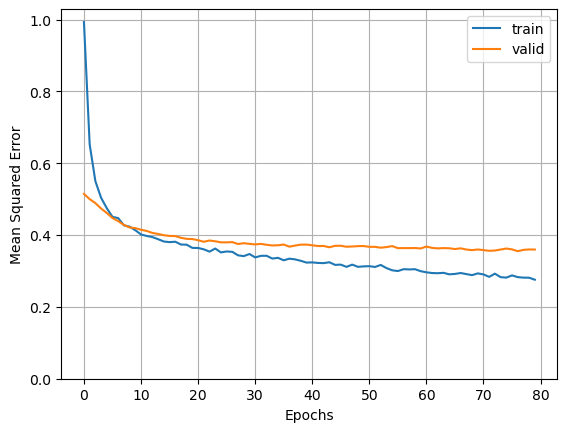

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


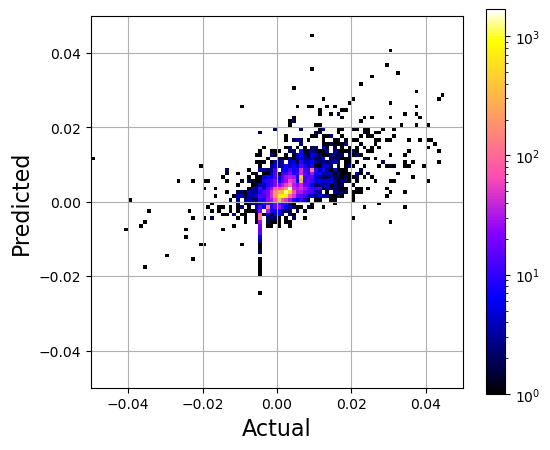

In [62]:
plot_loss(hist)
plot_act_pred()

The plot now shows a good evolution of the loss value.

### Along with the loss function, the structure of the CNN can be changed. I suggest seeing what happens when you do the following:
- `Change the Dense layers to have units=10`
- `Uncomment the additional MaxPooling2D and Conv2D layers`
- `Increase Conv2D filters to 64 and 128 respectively`
- `Change the loss function to mean_absolute_error`

Pay mind to how changing these parameters affect the number of parameters to train, how long training time becomes, and the 2D histogram of actual versus predicted OPGs. Feel free to try your own edits to inspect how it affects the testing outcome.

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 19, 27, 64)     │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 9, 13, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 9, 13, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 9, 13, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 4, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 4, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 100)            │       307,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 398,318 (1.52 MB)

 Trainable params: 398,062 (1.52 MB)

 Non-trainable params: 256 (1.00 KB)

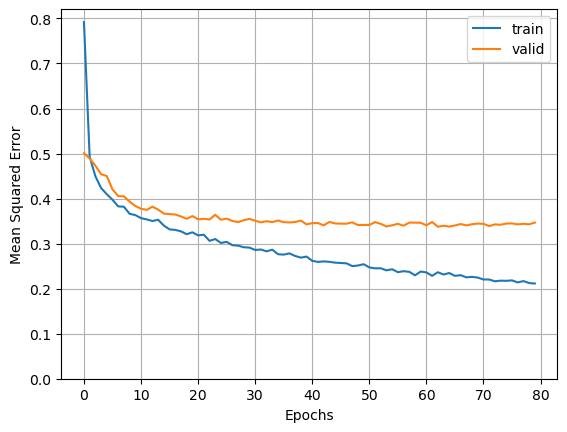

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


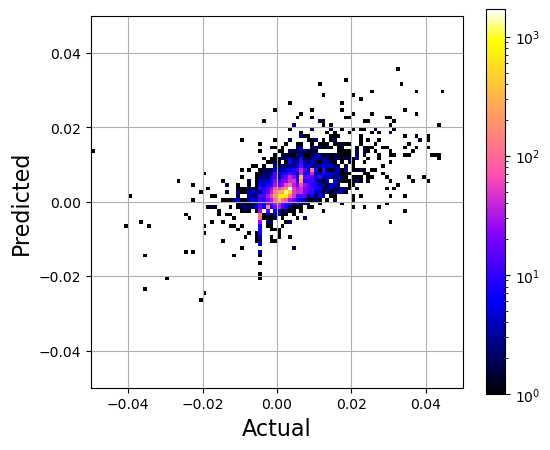

In [70]:
model = Sequential([  
    InputLayer(shape=(latitude, longitude, channels)),
    Conv2D(filters = 16, kernel_size = (3,3), padding = 'same', activation = 'relu'), # <-- Change the filter # of the Convolutional Layers
    MaxPooling2D(pool_size = (2,2)),
    Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu'), # <-- Change the filter # of the Convolutional Layers
    # MaxPooling2D(pool_size = (2,2)),
    # Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.25),
    Flatten(),
    Dense(units = 100, activation = 'relu'),  # <-- Change the units of the Dense Layers
    Dense(units = 100, activation = 'relu'),  # <-- Change the units of the Dense Layers
    Dropout(.25),
    Dense(units = len(facet_list), activation = 'linear')

model.summary()

model.compile(loss = 'mean_squared_error',          # <-- Change Loss Function Here
              metrics = ["mean_absolute_error", "mean_squared_error"], 
              optimizer = RMSprop(learning_rate=1e-4))

epochs = 80
hist = model.fit(train_atmos, train_opg, 
                  batch_size = batch_size,
                  epochs = epochs,                      
                  validation_data = (val_atmos, val_opg),
                  verbose = 0)                     # <-- If you want to silence training, set to 0, if you want to watch it train, set to 1

plot_loss(hist)
plot_act_pred()

Notice the differences between outputs when changing the hyperparameters:
- `Change the Dense layers to have units=10` - The mean squared error flatlines and the predicted versus actual look terrible.
- `Uncomment the additional MaxPooling2D and Conv2D layers` - Additional filters did not better the
- `Increase Conv2D filters to 64 and 128 respectively` - Additional filters did not better the
- `Change the loss function to mean_absolute_error` - The shape of the predicted versus actual changes.

What you choose for hyperparameters and structure all depends on what your goals are. 


### Model evaluation

We'll now evaluate this model on the set of test images. Normally, we'd retrain the model using the full training set (including the validation set), but to save time, we'll just proceed with the existing model. In order to do this, we first need to create a new image generator for the test images:

### One way to evaluate the model is to look at the actual versus predicted OPGs

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


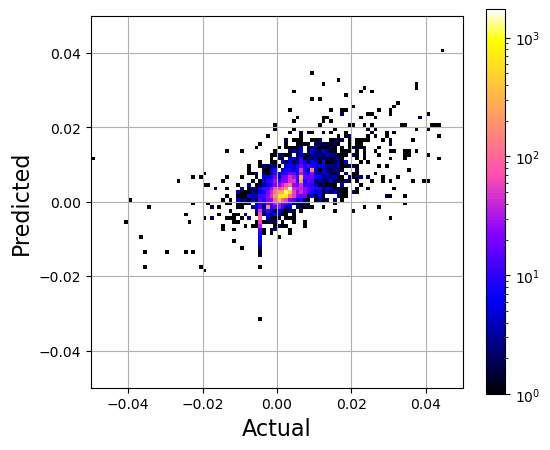

In [64]:
# Using our fitted model, predict OPGs from the testing subset.
predicted = model.predict(test_atmos)

# Convert from standardized OPG to mm/m OPG
actual    = (test_opg * opg_std) + opg_mean
predicted = (predicted * opg_std) + opg_mean

# Since days without OPG observations are set to zero, lets reshape our OPGs and remove zero OPG days
actual    = np.reshape(actual, -1)
predicted = np.reshape(predicted, -1)
idx       = actual != 0.0 # Identify days with OPG observations
actual    = actual[idx]
predicted = predicted[idx]

# Formulate the x and y axis limits
max_val = np.max((np.max(predicted[:]), np.max(actual[:])))
min_val = np.min((np.min(predicted[:]), np.min(actual[:])))
max_val = 0.05
min_val = -0.05

# Define plot colormap
cmap_gnuplot2 = ncm.cmap("MPL_gnuplot2")

# Define label sizes
label_size = 16
tick_size = 14

# Create Figure
plt.figure(figsize=(6, 5))

# Formulate the heatmap variables
heatmap, xedges, yedges = np.histogram2d(np.reshape(actual, -1), np.reshape(predicted, -1), bins=100,
                             range=[[min_val, max_val],[min_val, max_val]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Plot heatmap
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cmap_gnuplot2, norm=colors.LogNorm())

# Add labels, gridlines, and colorbar
plt.xlabel("Actual", fontsize=label_size)
plt.ylabel("Predicted", fontsize=label_size)
plt.grid(True)
plt.colorbar()

In [65]:
test_image_files_path = path + "Test"
# test images
test_data_gen = ImageDataGenerator(
    rescale = 1./255
)
test_image_array_gen = test_data_gen.flow_from_directory(test_image_files_path, 
                                                         target_size = target_size,
                                                         classes = fruit_list,
                                                         class_mode = 'categorical',
                                                         shuffle = False,
                                                         seed = 42)

NameError: name 'ImageDataGenerator' is not defined

The only differences here from the previous code is that we use the test image folder, and we no longer specify a validation parameter. Now we can use this to evaluate the model:

In [ ]:
test_loss, test_acc = model.evaluate(test_image_array_gen)

In [ ]:
print('Cross-entropy loss: %.4f'
      % test_loss)
print('Accuracy: %.4f'
      % test_acc)

Which gives us an accuracy of close to 1, which is a very good classifier. It is worth noting that this is partly because the images have all been cleaned and prepared; achieving this level of accuracy with images take 'in the wild' would require much more work in setting up and training the model.

### Convolutional Layers

### Grad-CAM

### Downscaling